In [2]:
# IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# DEFINE CUNY CAMPUS LOCATIONS WITH THEIR NEAREST SUBWAY/BUS STATIONS
cuny_campuses = {
    '4-year': {
        'Baruch College': {
            'location': (40.7401, -73.9838),
            'subway_stations': ['23 St', 'Lexington Av/63 St'],
            'bus_routes': ['M1', 'M2', 'M3', 'M15', 'M101']
        },
        'Hunter College': {
            'location': (40.7686, -73.9648),
            'subway_stations': ['68 St-Hunter College', '77 St'],
            'bus_routes': ['M15', 'M66', 'M72', 'M98', 'M101', 'M102', 'M103']
        },
        'City College': {
            'location': (40.8200, -73.9493),
            'subway_stations': ['137 St-City College', '145 St'],
            'bus_routes': ['M3', 'M4', 'M5', 'M100', 'M101', 'Bx33']
        }
    },
    '2-year': {
        'BMCC': {
            'location': (40.7182, -74.0132),
            'subway_stations': ['Chambers St', 'Park Place'],
            'bus_routes': ['M20', 'M22', 'M9']
        },
        'LaGuardia CC': {
            'location': (40.7441, -73.9345),
            'subway_stations': ['33 St-Rawson St', '40 St-Lowery St'],
            'bus_routes': ['Q39', 'Q60', 'Q67']
        },
        'Hostos CC': {
            'location': (40.8181, -73.9279),
            'subway_stations': ['149 St-Grand Concourse', '3 Av-149 St'],
            'bus_routes': ['Bx1', 'Bx2', 'Bx19']
        }
    }
}

In [3]:
# LOAD AND PREPARE DATA FOR CUNY ANALYSIS
def prepare_cuny_data(subway_df, bus_df):
    """
    Filters and prepares transit data for analyzing ridership around CUNY campuses.
    We specifically look at stations and routes near each campus location.
    """
    # CREATE EMPTY DICTIONARIES TO STORE FILTERED DATA
    cuny_transit_data = {
        '4-year': {'subway': [], 'bus': []},
        '2-year': {'subway': [], 'bus': []}
    }
    
    # PROCESS EACH CAMPUS TYPE AND LOCATION
    for campus_type, campuses in cuny_campuses.items():
        for campus_name, info in campuses.items():
            # FILTER SUBWAY DATA FOR NEARBY STATIONS
            campus_subway = subway_df[
                subway_df['station_complex'].str.contains(
                    '|'.join(info['subway_stations']), 
                    na=False
                )
            ].copy()
            campus_subway['campus'] = campus_name
            
            # FILTER BUS DATA FOR NEARBY ROUTES
            campus_bus = bus_df[
                bus_df['bus_route'].isin(info['bus_routes'])
            ].copy()
            campus_bus['campus'] = campus_name
            
            # ADD TO RESPECTIVE LISTS
            cuny_transit_data[campus_type]['subway'].append(campus_subway)
            cuny_transit_data[campus_type]['bus'].append(campus_bus)
    
    # COMBINE DATA FOR EACH TYPE
    for campus_type in cuny_transit_data:
        cuny_transit_data[campus_type]['subway'] = pd.concat(
            cuny_transit_data[campus_type]['subway'], 
            ignore_index=True
        )
        cuny_transit_data[campus_type]['bus'] = pd.concat(
            cuny_transit_data[campus_type]['bus'], 
            ignore_index=True
        )
    
    return cuny_transit_data

# LET'S TRY TO LOAD AND PREPARE THE DATA
try:
    print("LOADING TRANSIT DATA...")
    subway_df = pd.read_csv('../data/processed/subway_cleaned.csv')
    bus_df = pd.read_csv('../data/processed/bus_cleaned.csv')
    
    print("PREPARING CUNY ANALYSIS DATA...")
    cuny_data = prepare_cuny_data(subway_df, bus_df)
    
    # PRINT INITIAL SUMMARY
    for campus_type in cuny_data:
        print(f"\n{campus_type.upper()} COLLEGES:")
        print(f"Number of subway rides: {cuny_data[campus_type]['subway']['ridership'].sum():,.0f}")
        print(f"Number of bus rides: {cuny_data[campus_type]['bus']['ridership'].sum():,.0f}")
        
except Exception as e:
    print(f"AN ERROR OCCURRED: {str(e)}")

LOADING TRANSIT DATA...


/var/folders/ch/bc17btyj5dz4wbcv2s90_kz40000gn/T/ipykernel_1966/3112634358.py:51: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  subway_df = pd.read_csv('../data/processed/subway_cleaned.csv')


PREPARING CUNY ANALYSIS DATA...

4-YEAR COLLEGES:
Number of subway rides: 125,314,608
Number of bus rides: 118,828,301

2-YEAR COLLEGES:
Number of subway rides: 79,917,683
Number of bus rides: 18,222,031


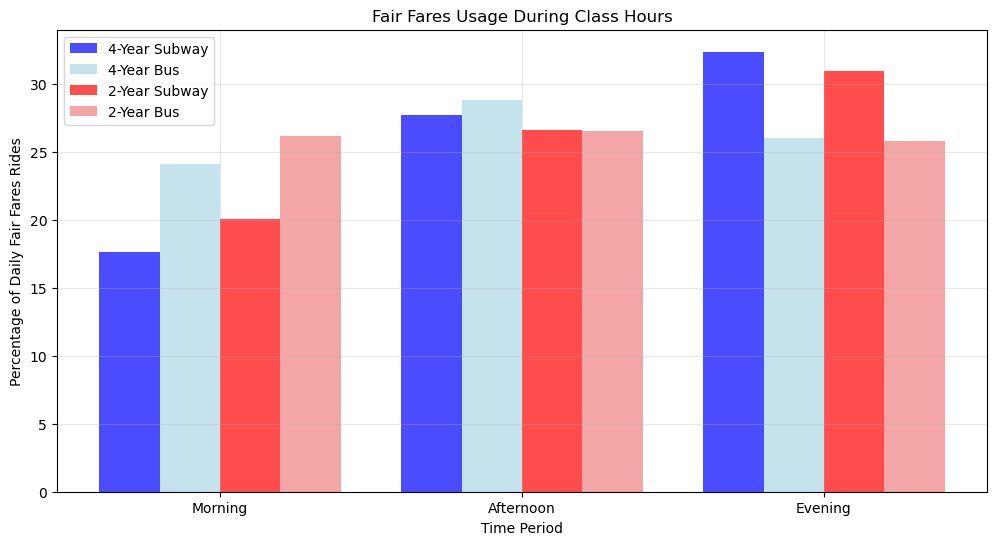


KEY INSIGHTS FROM CLASS HOUR ANALYSIS:

4-YEAR COLLEGES:

SUBWAY USAGE:
Morning: 17.6%
Afternoon: 27.7%
Evening: 32.4%

BUS USAGE:
Morning: 24.1%
Afternoon: 28.8%
Evening: 26.0%

2-YEAR COLLEGES:

SUBWAY USAGE:
Morning: 20.1%
Afternoon: 26.6%
Evening: 30.9%

BUS USAGE:
Morning: 26.2%
Afternoon: 26.5%
Evening: 25.8%


In [4]:
# ANALYZE FAIR FARES USAGE PATTERNS DURING CLASS HOURS
def analyze_class_hour_patterns(cuny_data):
    """
    Analyzes Fair Fares ridership during typical class hours:
    Morning: 8AM-12PM
    Afternoon: 12PM-4PM
    Evening: 4PM-8PM
    """
    time_periods = {
        'Morning': range(8, 12),
        'Afternoon': range(12, 16),
        'Evening': range(16, 20)
    }
    
    analysis_results = {
        '4-year': {'subway': {}, 'bus': {}},
        '2-year': {'subway': {}, 'bus': {}}
    }
    
    for campus_type in ['4-year', '2-year']:
        for mode in ['subway', 'bus']:
            # FILTER FOR FAIR FARES RIDES
            fair_fares_rides = cuny_data[campus_type][mode][
                cuny_data[campus_type][mode]['fare_class_category'].str.contains('Fair Fare')
            ]
            
            # ANALYZE EACH TIME PERIOD
            for period, hours in time_periods.items():
                period_rides = fair_fares_rides[
                    fair_fares_rides['hour'].isin(hours)
                ]
                
                analysis_results[campus_type][mode][period] = {
                    'total_rides': period_rides['ridership'].sum(),
                    'percentage': (period_rides['ridership'].sum() / 
                                 fair_fares_rides['ridership'].sum() * 100)
                }
    
    return analysis_results

# RUN THE ANALYSIS AND VISUALIZE
try:
    class_patterns = analyze_class_hour_patterns(cuny_data)
    
    # CREATE VISUALIZATION
    plt.figure(figsize=(12, 6))
    
    periods = ['Morning', 'Afternoon', 'Evening']
    x = np.arange(len(periods))
    width = 0.2
    
    # PLOT 4-YEAR COLLEGES
    plt.bar(x - width*1.5, 
           [class_patterns['4-year']['subway'][p]['percentage'] for p in periods],
           width, label='4-Year Subway', color='blue', alpha=0.7)
    plt.bar(x - width/2,
           [class_patterns['4-year']['bus'][p]['percentage'] for p in periods],
           width, label='4-Year Bus', color='lightblue', alpha=0.7)
    
    # PLOT 2-YEAR COLLEGES
    plt.bar(x + width/2,
           [class_patterns['2-year']['subway'][p]['percentage'] for p in periods],
           width, label='2-Year Subway', color='red', alpha=0.7)
    plt.bar(x + width*1.5,
           [class_patterns['2-year']['bus'][p]['percentage'] for p in periods],
           width, label='2-Year Bus', color='lightcoral', alpha=0.7)
    
    plt.title('Fair Fares Usage During Class Hours')
    plt.xlabel('Time Period')
    plt.ylabel('Percentage of Daily Fair Fares Rides')
    plt.xticks(x, periods)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.show()
    
    # PRINT KEY INSIGHTS
    print("\nKEY INSIGHTS FROM CLASS HOUR ANALYSIS:")
    print("=" * 50)
    for campus_type in ['4-year', '2-year']:
        print(f"\n{campus_type.upper()} COLLEGES:")
        for mode in ['subway', 'bus']:
            print(f"\n{mode.upper()} USAGE:")
            for period in periods:
                print(f"{period}: {class_patterns[campus_type][mode][period]['percentage']:.1f}%")
                
except Exception as e:
    print(f"AN ERROR OCCURRED: {str(e)}")

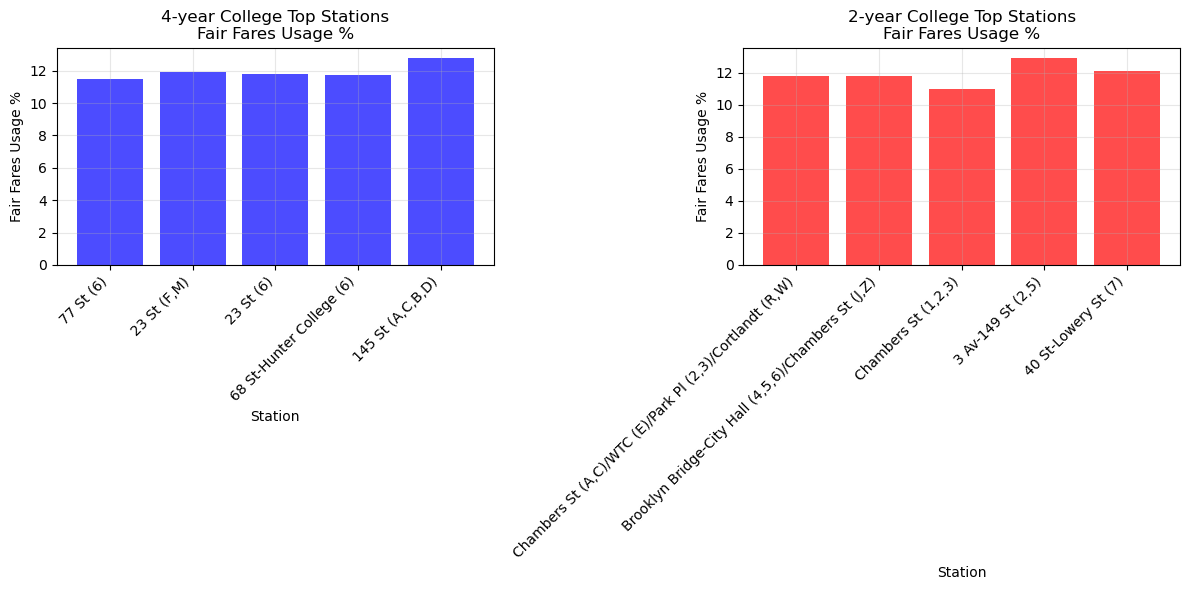


STATION-SPECIFIC INSIGHTS:

4-YEAR COLLEGES - TOP 5 STATIONS:

77 St (6):
- Total Ridership: 15,661,490
- Fair Fares Usage: 11.5%

23 St (F,M):
- Total Ridership: 13,884,555
- Fair Fares Usage: 11.9%

23 St (6):
- Total Ridership: 13,666,486
- Fair Fares Usage: 11.8%

68 St-Hunter College (6):
- Total Ridership: 12,844,781
- Fair Fares Usage: 11.8%

145 St (A,C,B,D):
- Total Ridership: 12,270,542
- Fair Fares Usage: 12.8%

2-YEAR COLLEGES - TOP 5 STATIONS:

Chambers St (A,C)/WTC (E)/Park Pl (2,3)/Cortlandt (R,W):
- Total Ridership: 31,187,649
- Fair Fares Usage: 11.8%

Brooklyn Bridge-City Hall (4,5,6)/Chambers St (J,Z):
- Total Ridership: 14,843,122
- Fair Fares Usage: 11.8%

Chambers St (1,2,3):
- Total Ridership: 9,558,073
- Fair Fares Usage: 11.0%

3 Av-149 St (2,5):
- Total Ridership: 8,996,622
- Fair Fares Usage: 12.9%

40 St-Lowery St (7):
- Total Ridership: 5,562,751
- Fair Fares Usage: 12.1%


In [5]:
# ANALYZE STATION-SPECIFIC PATTERNS AND FAIR FARES ADOPTION
def analyze_station_patterns(cuny_data):
    """
    Analyzes Fair Fares usage patterns at specific stations near CUNY campuses
    """
    station_analysis = {
        '4-year': {},
        '2-year': {}
    }
    
    for campus_type in ['4-year', '2-year']:
        # GROUP BY STATION AND CALCULATE METRICS
        station_stats = cuny_data[campus_type]['subway'].groupby('station_complex').agg({
            'ridership': 'sum',
            'fare_class_category': lambda x: (
                x.str.contains('Fair Fare').sum() / len(x) * 100
            )
        }).round(2)
        
        # SORT BY RIDERSHIP
        station_stats = station_stats.sort_values('ridership', ascending=False)
        
        # STORE RESULTS
        station_analysis[campus_type] = station_stats
    
    # CREATE VISUALIZATION
    plt.figure(figsize=(12, 6))
    
    # PLOT TOP 5 STATIONS FOR EACH COLLEGE TYPE
    for i, campus_type in enumerate(['4-year', '2-year']):
        plt.subplot(1, 2, i+1)
        top_stations = station_analysis[campus_type].head(5)
        
        plt.bar(range(len(top_stations)), 
               top_stations['fare_class_category'],
               alpha=0.7,
               color='blue' if campus_type == '4-year' else 'red')
        
        plt.title(f'{campus_type} College Top Stations\nFair Fares Usage %')
        plt.xlabel('Station')
        plt.ylabel('Fair Fares Usage %')
        plt.xticks(range(len(top_stations)), 
                  top_stations.index,
                  rotation=45,
                  ha='right')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # PRINT DETAILED STATION INSIGHTS
    print("\nSTATION-SPECIFIC INSIGHTS:")
    print("=" * 50)
    for campus_type in ['4-year', '2-year']:
        print(f"\n{campus_type.upper()} COLLEGES - TOP 5 STATIONS:")
        top_stations = station_analysis[campus_type].head()
        for station, data in top_stations.iterrows():
            print(f"\n{station}:")
            print(f"- Total Ridership: {data['ridership']:,.0f}")
            print(f"- Fair Fares Usage: {data['fare_class_category']:.1f}%")

try:
    analyze_station_patterns(cuny_data)
except Exception as e:
    print(f"AN ERROR OCCURRED: {str(e)}")


4-YEAR COLLEGE TRANSFER PATTERNS:

Top Transfer Stations:

Lexington Av/63 St (F,Q):
- Average Transfers: 1.69
- Daily Ridership: 244,070

68 St-Hunter College (6):
- Average Transfers: 1.01
- Daily Ridership: 464,002

145 St (A,C,B,D):
- Average Transfers: 0.74
- Daily Ridership: 637,952

145 St (1):
- Average Transfers: 0.53
- Daily Ridership: 268,911

23 St (6):
- Average Transfers: 0.52
- Daily Ridership: 411,104

2-YEAR COLLEGE TRANSFER PATTERNS:

Top Transfer Stations:

3 Av-149 St (2,5):
- Average Transfers: 3.41
- Daily Ridership: 731,530

149 St-Grand Concourse (2,4,5):
- Average Transfers: 1.09
- Daily Ridership: 369,332


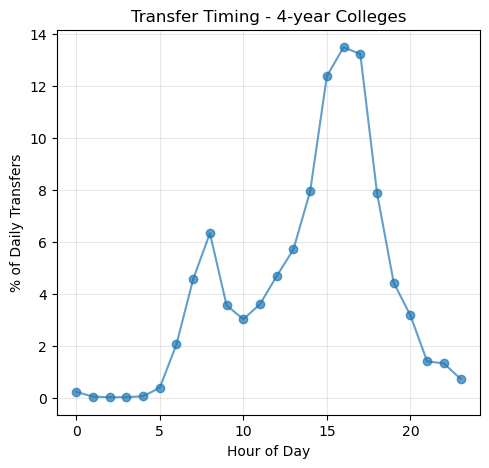

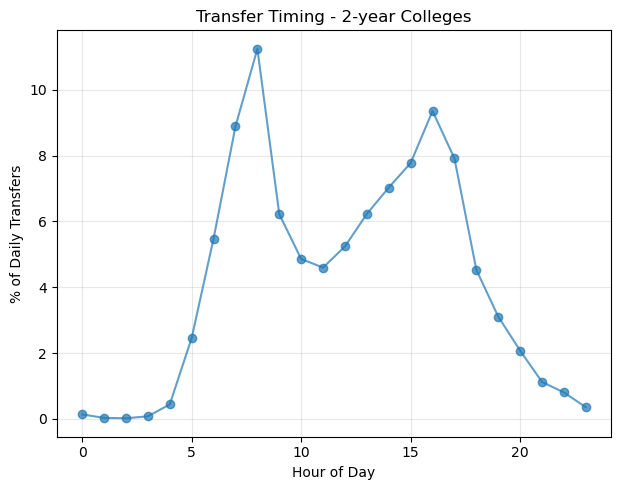

In [6]:
# ANALYZE TRANSFER PATTERNS AND INTER-CAMPUS CONNECTIVITY
def analyze_transfer_patterns(cuny_data):
    """
    Examines how Fair Fares users navigate between stations and potentially between campuses,
    focusing on transfer patterns and multi-leg journeys.
    """
    for campus_type in ['4-year', '2-year']:
        # FILTER FOR FAIR FARES RIDES
        fair_fares_data = cuny_data[campus_type]['subway'][
            cuny_data[campus_type]['subway']['fare_class_category'].str.contains('Fair Fare')
        ]
        
        # ANALYZE TRANSFERS
        transfer_stats = fair_fares_data.groupby('station_complex').agg({
            'transfers': ['mean', 'median', 'max'],
            'ridership': 'sum'
        })
        
        # CALCULATE PEAK TRANSFER TIMES
        transfer_times = fair_fares_data[
            fair_fares_data['transfers'] > 0
        ].groupby('hour')['ridership'].sum()
        
        # CREATE VISUALIZATION
        plt.figure(figsize=(12, 5))
        
        # PLOT TRANSFER PATTERNS
        plt.subplot(1, 2, 1)
        plt.plot(transfer_times.index, 
                transfer_times.values / transfer_times.values.sum() * 100,
                marker='o',
                label=campus_type,
                alpha=0.7)
        plt.title(f'Transfer Timing - {campus_type} Colleges')
        plt.xlabel('Hour of Day')
        plt.ylabel('% of Daily Transfers')
        plt.grid(True, alpha=0.3)
        
        # PRINT KEY FINDINGS
        print(f"\n{campus_type.upper()} COLLEGE TRANSFER PATTERNS:")
        print("=" * 40)
        
        # IDENTIFY HIGH-TRANSFER STATIONS
        high_transfer = transfer_stats[
            transfer_stats[('transfers', 'mean')] > 0.5
        ].sort_values(('transfers', 'mean'), ascending=False)
        
        print("\nTop Transfer Stations:")
        for station in high_transfer.head().index:
            print(f"\n{station}:")
            print(f"- Average Transfers: {high_transfer.loc[station, ('transfers', 'mean')]:.2f}")
            print(f"- Daily Ridership: {high_transfer.loc[station, ('ridership', 'sum')]:,.0f}")
    
    plt.tight_layout()
    plt.show()

# RUN THE ANALYSIS
try:
    analyze_transfer_patterns(cuny_data)
except Exception as e:
    print(f"AN ERROR OCCURRED: {str(e)}")

In [7]:
# GENERATE COMPREHENSIVE RECOMMENDATIONS
def generate_final_recommendations():
    """
    Creates detailed recommendations based on all analyses of Fair Fares usage
    around CUNY campuses.
    """
    recommendations = {
        'Service Improvements': {
            '4-year': [
                "Increase afternoon service frequency (2-4 PM) to accommodate peak transfer times",
                "Focus on improving connection reliability at Lexington Av/63 St station",
                "Consider express bus service between major transfer hubs during class transition times"
            ],
            '2-year': [
                "Prioritize morning (8-10 AM) service reliability for high-transfer stations",
                "Improve signage and wayfinding at 3 Av-149 St complex",
                "Consider dedicated bus routes connecting major transfer points to campuses"
            ]
        },
        'Program Enhancements': [
            "Establish Fair Fares enrollment centers at campus welcome centers",
            "Create targeted outreach programs during college orientation periods",
            "Develop inter-campus transit guides specifically for Fair Fares users",
            "Partner with CUNY to integrate Fair Fares information into course registration"
        ],
        'Infrastructure': [
            "Install real-time transfer information displays at high-volume stations",
            "Improve weather protection at major transfer points",
            "Add MetroCard vending machines at campus buildings",
            "Create dedicated waiting areas for campus-bound bus routes"
        ]
    }
    
    return recommendations

# PRINT FINAL RECOMMENDATIONS
try:
    final_recs = generate_final_recommendations()
    
    print("\nFINAL RECOMMENDATIONS FOR FAIR FARES CUNY IMPROVEMENT:")
    print("=" * 60)
    
    for category, items in final_recs.items():
        print(f"\n{category.upper()}:")
        
        if isinstance(items, dict):
            for college_type, recs in items.items():
                print(f"\n{college_type} Colleges:")
                for rec in recs:
                    print(f"- {rec}")
        else:
            for rec in items:
                print(f"- {rec}")

except Exception as e:
    print(f"AN ERROR OCCURRED: {str(e)}")


FINAL RECOMMENDATIONS FOR FAIR FARES CUNY IMPROVEMENT:

SERVICE IMPROVEMENTS:

4-year Colleges:
- Increase afternoon service frequency (2-4 PM) to accommodate peak transfer times
- Focus on improving connection reliability at Lexington Av/63 St station
- Consider express bus service between major transfer hubs during class transition times

2-year Colleges:
- Prioritize morning (8-10 AM) service reliability for high-transfer stations
- Improve signage and wayfinding at 3 Av-149 St complex
- Consider dedicated bus routes connecting major transfer points to campuses

PROGRAM ENHANCEMENTS:
- Establish Fair Fares enrollment centers at campus welcome centers
- Create targeted outreach programs during college orientation periods
- Develop inter-campus transit guides specifically for Fair Fares users
- Partner with CUNY to integrate Fair Fares information into course registration

INFRASTRUCTURE:
- Install real-time transfer information displays at high-volume stations
- Improve weather prot